In [ ]:
import numpy as np
import math
import jax
import jax.numpy as jnp
import os
import pickle
import jax
import math
from flax.training import checkpoints
import matplotlib.pyplot as plt

from models.models_1.gumbel_experiments import (
    ConcreteAutoencoder,
    create_train_state,
    train_for_epochs,
)

gpu_devices = jax.devices("gpu")
if gpu_devices:
    device = gpu_devices[0]
else:
    device = jax.devices("cpu")[0]

num_epochs = 1000
batch_size = 16
initial_lr = 1e-1
min_temp = 0.01
start_temp = 10.

with open("../data/mnist_data.pkl", 'rb') as f:
    mnist_data = pickle.load(f)


x_train = mnist_data['x_train']
x_test = mnist_data['x_test']

x_train = x_train[:1000]
x_test = x_test[:200]

Nh_val = x_train.shape[1]
r_val = 20

steps_per_epoch = (x_train.shape[0] + batch_size - 1) // batch_size
alpha_const = math.exp(math.log(min_temp / start_temp) / (num_epochs * steps_per_epoch))


rng = jax.random.PRNGKey(0)
model = ConcreteAutoencoder(
    min_temp     = min_temp,
    start_temp   = start_temp,
    alpha_const  = alpha_const,
    enc_inp_dim  = Nh_val,
    enc_out_dim  = r_val
)

restored_state = create_train_state(
    rng,
    model,
    input_shape=(batch_size, Nh_val),
    lr=initial_lr,
)

results_dir = f'/workspace/venu_files/climate_forecasting/CAE_transf/results/mnist_example_ne{num_epochs}_lr{initial_lr}_Nval{Nh_val}_rval{r_val}_nogumbel/'
os.makedirs(f"{results_dir}", exist_ok=True)


CKPT_DIR = f"{results_dir}checkpoints"
os.makedirs(CKPT_DIR, exist_ok=True)

restored_state = checkpoints.restore_checkpoint(
    ckpt_dir=CKPT_DIR,
    target=restored_state       # will be replaced with the latest checkpoint
)

# results:
# 1. test data predictions comparison:

from models.models_1.gumbel_experiments import (
    Decoder
)


with open(results_dir + "final_results.pkl", "rb") as file:
    final_results = pickle.load(file)

train_loss_hist = final_results['train_loss_hist']
val_loss_hist = final_results['val_loss_hist']
mean_max_prob = final_results['mean_max_prob']
logit_vals_hist = final_results['logit_vals_hist']
best_train_loss = final_results['best_train_loss']
best_val_loss = final_results['best_val_loss']

best_logits = logit_vals_hist[np.argmin(val_loss_hist)]
selected_indices = jnp.argmax(best_logits, axis=1)

S_test_sel = jnp.take(x_test, selected_indices, axis = 1)

decoder_params = restored_state.params['decoder']

encoder_input_dim = Nh_val
encoder_output_dim = r_val

Decoder_module_tester = Decoder(output_dim=encoder_input_dim)

S_test_pred = Decoder_module_tester.apply({'params': decoder_params}, S_test_sel, deterministic=True, mutable=False)

In [ ]:
# print(test_preds.shape)

(200, 784)


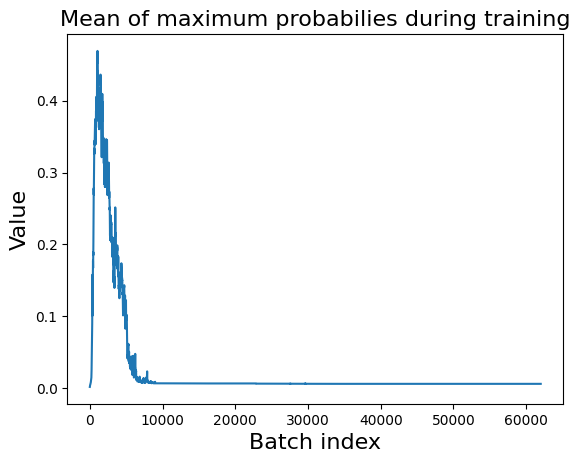

In [5]:
plt.plot(mean_max_prob)
plt.xlabel('Batch index', fontsize = 16)
plt.ylabel('Value', fontsize = 16)
plt.title('Mean of maximum probabilies during training', fontsize = 16)
plt.savefig(f'{results_dir}mean_max_prob.png')

In [9]:
print(S_test_pred.shape, x_test.shape)

(200, 784) (200, 784)


0.6995079695481967 : 1.0259826570541142


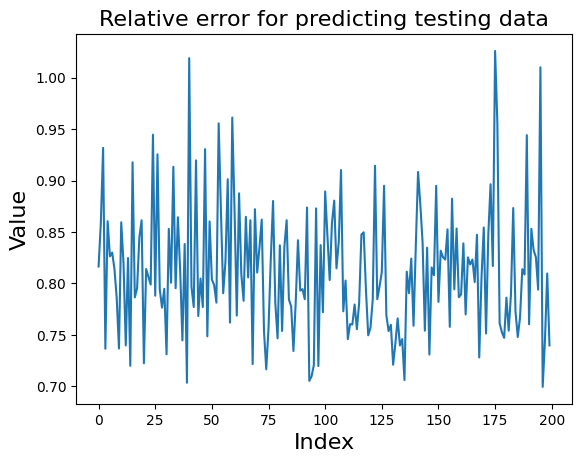

In [10]:
test_pred_errs = []
for i in range(x_test.shape[0]):
    test_pred_errs.append(np.linalg.norm(x_test[i] - S_test_pred[i])/ np.linalg.norm(x_test[i]))

np.save(f'{results_dir}test_pred_err_vals.npy', test_pred_errs)

plt.plot(test_pred_errs)
plt.xlabel('Index', fontsize = 16)
plt.ylabel('Value', fontsize = 16)
plt.title('Relative error for predicting testing data', fontsize = 16)
plt.savefig(f'{results_dir}test_pred_errs.png')
print(np.array(test_pred_errs).min(), ":", np.array(test_pred_errs).max())

714330.544 : 2306797.55
18.86754608154297 : 747.08203125


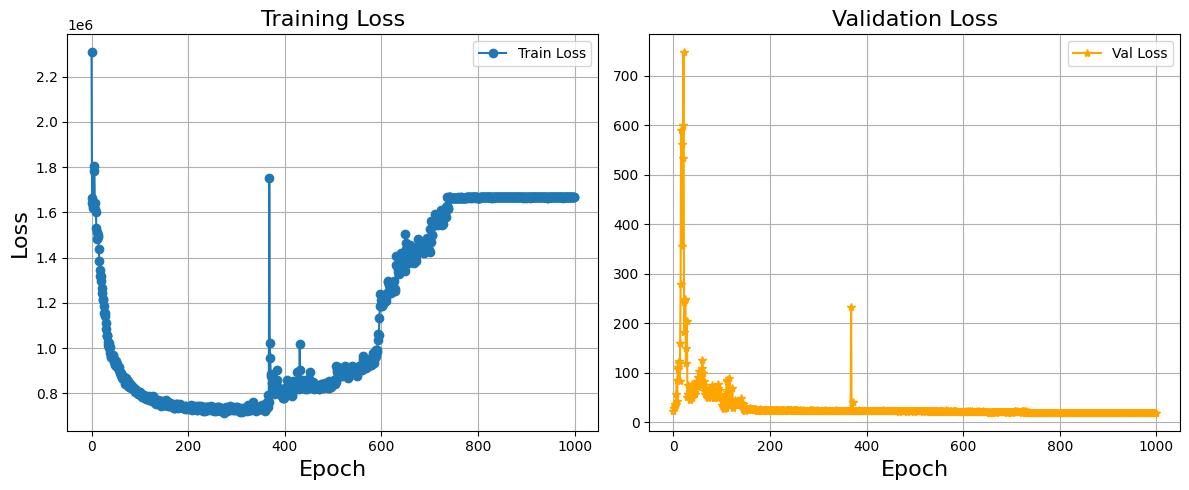

In [11]:
# 2. train and validation loss hist:
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

# Left: training loss
axes[0].plot(train_loss_hist, marker='o', label='Train Loss')
axes[0].set_title('Training Loss', fontsize = 16)
axes[0].set_xlabel('Epoch', fontsize = 16)
axes[0].set_ylabel('Loss', fontsize = 16)
axes[0].grid(True)
axes[0].legend()

# Right: validation loss
axes[1].plot(val_loss_hist, marker='*', color='orange', label='Val Loss')
axes[1].set_title('Validation Loss', fontsize = 16)
axes[1].set_xlabel('Epoch', fontsize = 16)
axes[1].grid(True)
axes[1].legend()
plt.tight_layout()
plt.savefig(f'{results_dir}testing_validation_loss.png')
# plt.show()


print(np.array(train_loss_hist).min(), ':', np.array(train_loss_hist).max())
print(np.array(val_loss_hist).min(), ':', np.array(val_loss_hist).max())


In [8]:
# print(selected_indices)
print(np.unique(selected_indices))

[18496 20347 22381]


(22701, 985)


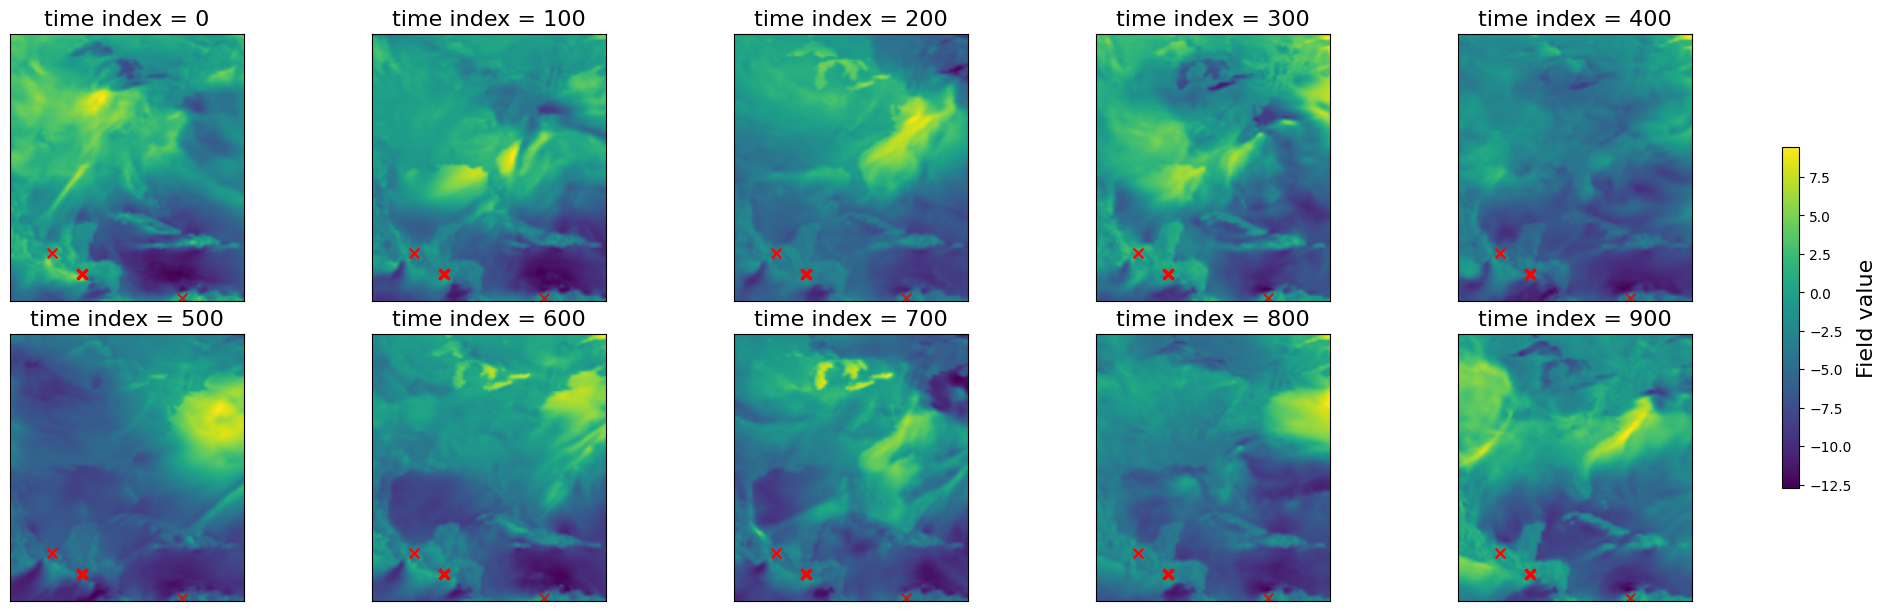

In [5]:
print(S_train.shape)
S_train_org = S_train.reshape((len(lat_vals), len(lon_vals), S_train.shape[1]))
height, width, n_time = S_train_org.shape
lon2d, lat2d = np.meshgrid(lon_vals, lat_vals)  

lon_flat = lon2d.ravel()    # shape (22701,)
lat_flat = lat2d.ravel()

# # pick out the real-world coordinates
selected_lons = lon_flat[selected_indices]
selected_lats = lat_flat[selected_indices]

times_to_plot = np.arange(0, 1000, 100)   # [0,100,200,…,900]
n_plots = len(times_to_plot)

# layout: e.g. 2 rows × 5 columns
ncols = 5
nrows = int(np.ceil(n_plots / ncols))

fig, axes = plt.subplots(
    nrows, ncols,
    figsize=(4*ncols, 3*nrows),
    constrained_layout=True
)

axes = axes.ravel()

for ax, t in zip(axes, times_to_plot):
    im = ax.imshow(
        S_train_org[:, :, t],
        cmap='viridis',
        origin='upper',
        extent=[
            lon_vals.min(), lon_vals.max(),
            lat_vals.min(), lat_vals.max()
        ]
    )

    ax.scatter(
    selected_lons,   
    selected_lats,   
    c='r',
    marker='x',
    s=50,
    label='selected'
    )

    ax.set_title(f"time index = {t}", fontsize = 16)
    ax.set_xticks([])
    ax.set_yticks([])

for ax in axes[n_plots:]:
    ax.axis("off")

cbar = fig.colorbar(im, ax=axes[:n_plots].tolist(), shrink=0.6)
cbar.set_label("Field value", fontsize = 16)
plt.savefig(f'{results_dir}u10m_selected_points_time_series.png')
# plt.show()

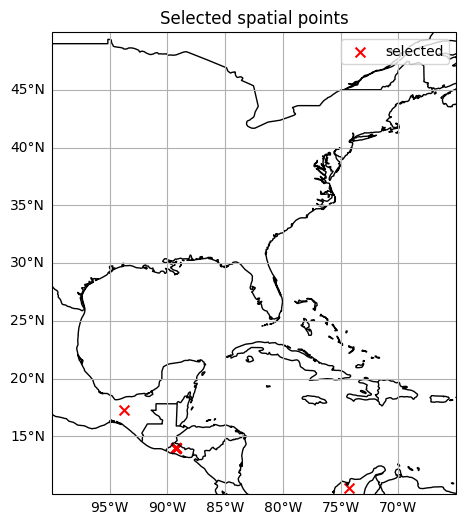

In [6]:
import cartopy.crs as ccrs
import cartopy.feature as cfeature

fig = plt.figure(figsize=(8, 6))

ax = plt.axes(projection=ccrs.PlateCarree())

lon_min = lon_vals.min()
lon_max = lon_vals.max()

lat_min = lat_vals.min()
lat_max = lat_vals.max()


ax.set_extent([lon_min, lon_max, lat_min, lat_max], crs=ccrs.PlateCarree())

ax.add_feature(cfeature.COASTLINE.with_scale("50m"))
ax.add_feature(cfeature.BORDERS.with_scale("50m"))

# scatter the points (specify the PlateCarree transform)
ax.scatter(
    selected_lons,
    selected_lats,
    c="red",
    marker="x",
    s=50,
    transform=ccrs.PlateCarree(),
    label="selected"
)

# add gridlines
gl = ax.gridlines(draw_labels=True, dms=True, x_inline=False, y_inline=False)
gl.top_labels = gl.right_labels = False

ax.set_title("Selected spatial points")
ax.legend(loc="upper right")
plt.savefig(f'{results_dir}u10m_selected_points_map.png')

selected_coords = {
    'selected_lons': selected_lons,
    'selected_lats': selected_lats,
}

with open(f'{results_dir}selected_coords.pkl', 'wb') as f:
    pickle.dump(selected_coords, f)

# plt.show()

In [9]:
# comparison of epoch training.

# 1. testing pred error vals.
test_dir1 = f'/workspace/venu_files/climate_forecasting/CAE_transf/results/ne1_lr{initial_lr}_Nval{Nh_val}_rval{r_val}_m2/'
test_dir10 = f'/workspace/venu_files/climate_forecasting/CAE_transf/results/ne10_lr{initial_lr}_Nval{Nh_val}_rval{r_val}_m2/'
test_dir100 = f'/workspace/venu_files/climate_forecasting/CAE_transf/results/ne100_lr{initial_lr}_Nval{Nh_val}_rval{r_val}_m2/'
test_dir1000 = f'/workspace/venu_files/climate_forecasting/CAE_transf/results/ne1000_lr{initial_lr}_Nval{Nh_val}_rval{r_val}_m2/'


with open(test_dir1 + "final_results.pkl", "rb") as file:
    final_results_1 = pickle.load(file)

train_loss_hist_1 = final_results_1['train_loss_hist']
val_loss_hist_1 =   final_results_1['val_loss_hist']
mean_max_prob_1 =   final_results_1['mean_max_prob']
logit_vals_hist_1 = final_results_1['logit_vals_hist']
best_train_loss_1 = final_results_1['best_train_loss']
best_val_loss_1 =   final_results_1['best_val_loss']

with open(test_dir10 + "final_results.pkl", "rb") as file:
    final_results_10 = pickle.load(file)

train_loss_hist_10 = final_results_10['train_loss_hist']
val_loss_hist_10 =   final_results_10['val_loss_hist']
mean_max_prob_10 =   final_results_10['mean_max_prob']
logit_vals_hist_10 = final_results_10['logit_vals_hist']
best_train_loss_10 = final_results_10['best_train_loss']
best_val_loss_10 =   final_results_10['best_val_loss']


with open(test_dir100 + "final_results.pkl", "rb") as file:
    final_results_100 = pickle.load(file)

train_loss_hist_100 = final_results_100['train_loss_hist']
val_loss_hist_100 =   final_results_100['val_loss_hist']
mean_max_prob_100 =   final_results_100['mean_max_prob']
logit_vals_hist_100 = final_results_100['logit_vals_hist']
best_train_loss_100 = final_results_100['best_train_loss']
best_val_loss_100 =   final_results_100['best_val_loss']


with open(test_dir1000 + "final_results.pkl", "rb") as file:
    final_results_1000 = pickle.load(file)

train_loss_hist_1000 = final_results_1000['train_loss_hist']
val_loss_hist_1000 =   final_results_1000['val_loss_hist']
mean_max_prob_1000 =   final_results_1000['mean_max_prob']
logit_vals_hist_1000 = final_results_1000['logit_vals_hist']
best_train_loss_1000 = final_results_1000['best_train_loss']
best_val_loss_1000 =   final_results_1000['best_val_loss']



# 2. scatter points on map with label.
# 3. mean max prob

In [ ]:
# print(len(mean_max_prob_1), len(mean_max_prob_10), len(mean_max_prob_100), len(mean_max_prob_1000) ) # 61 610 3660 13115

61 610 3660 13115


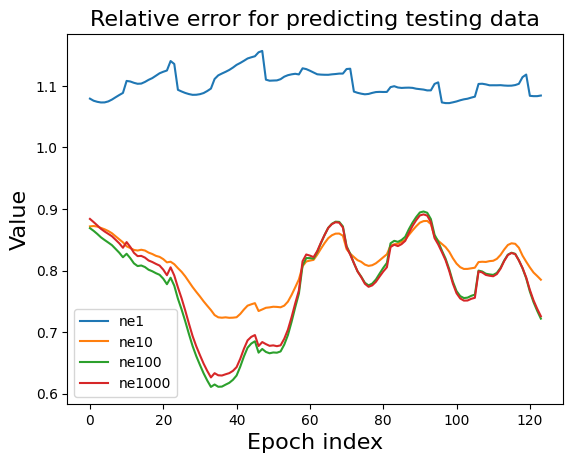

In [10]:
test_pred_errs_1 = np.load(f'{test_dir1}test_pred_err_vals.npy')
test_pred_errs_10 = np.load(f'{test_dir10}test_pred_err_vals.npy')
test_pred_errs_100 = np.load(f'{test_dir100}test_pred_err_vals.npy')
test_pred_errs_1000 = np.load(f'{test_dir1000}test_pred_err_vals.npy')

plt.plot(test_pred_errs_1, label = 'ne1')
plt.plot(test_pred_errs_10, label = 'ne10')
plt.plot(test_pred_errs_100, label = 'ne100')
plt.plot(test_pred_errs_1000, label = 'ne1000')
plt.legend()
plt.xlabel('Epoch index', fontsize = 16)
plt.ylabel('Value', fontsize = 16)
plt.title('Relative error for predicting testing data', fontsize = 16)
plt.savefig(f'{test_dir1000}test_pred_errs_comparison.png')


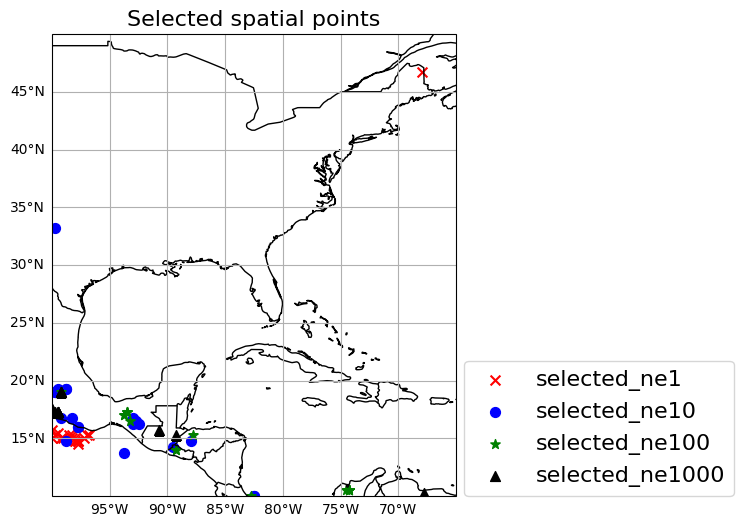

In [11]:
# selected spatial points comparison

selected_coords = {
    'selected_lons': selected_lons,
    'selected_lats': selected_lats,
}

with open(f'{test_dir1}selected_coords.pkl', 'rb') as f:
    selected_coords_1 = pickle.load(f)

with open(f'{test_dir10}selected_coords.pkl', 'rb') as f:
    selected_coords_10 = pickle.load(f)

with open(f'{test_dir100}selected_coords.pkl', 'rb') as f:
    selected_coords_100 = pickle.load(f)

with open(f'{test_dir1000}selected_coords.pkl', 'rb') as f:
    selected_coords_1000 = pickle.load(f)

selected_lons_1 = selected_coords_1['selected_lons']
selected_lats_1 = selected_coords_1['selected_lats']

selected_lons_10 = selected_coords_10['selected_lons']
selected_lats_10 = selected_coords_10['selected_lats']

selected_lons_100 = selected_coords_100['selected_lons']
selected_lats_100 = selected_coords_100['selected_lats']

selected_lons_1000 = selected_coords_1000['selected_lons']
selected_lats_1000 = selected_coords_1000['selected_lats']


fig = plt.figure(figsize=(8, 6))
ax = plt.axes(projection=ccrs.PlateCarree())

ax.set_extent([lon_min, lon_max, lat_min, lat_max], crs=ccrs.PlateCarree())

ax.add_feature(cfeature.COASTLINE.with_scale("50m"))
ax.add_feature(cfeature.BORDERS.with_scale("50m"))

# scatter the points (specify the PlateCarree transform)
ax.scatter(
    selected_lons_1,
    selected_lats_1,
    c="red",
    marker="x",
    s=50,
    transform=ccrs.PlateCarree(),
    label="selected_ne1"
)

ax.scatter(
    selected_lons_10,
    selected_lats_10,
    c="blue",
    marker="o",
    s=50,
    transform=ccrs.PlateCarree(),
    label="selected_ne10"
)

ax.scatter(
    selected_lons_100,
    selected_lats_100,
    c="green",
    marker="*",
    s=50,
    transform=ccrs.PlateCarree(),
    label="selected_ne100"
)

ax.scatter(
    selected_lons_1000,
    selected_lats_1000,
    c="black",
    marker="^",
    s=50,
    transform=ccrs.PlateCarree(),
    label="selected_ne1000"
)


# add gridlines
gl = ax.gridlines(draw_labels=True, dms=True, x_inline=False, y_inline=False)
gl.top_labels = gl.right_labels = False
ax.set_title("Selected spatial points", fontsize = 16)
leg = ax.legend(loc='lower left', bbox_to_anchor=(1.02, 0.0), borderaxespad=0, fontsize = 16)
plt.subplots_adjust(right=0.78)
plt.savefig(f'{test_dir1000}u10m_selected_points_map.png')



(20, 22701)


/tmp/ipykernel_2219354/752736873.py:22: UserWarning: Adding colorbar to a different Figure <Figure size 1400x400 with 2 Axes> than <Figure size 800x600 with 1 Axes> which fig.colorbar is called on.
  cbar = fig.colorbar(im, ax=ax, orientation='horizontal', pad=0.2)


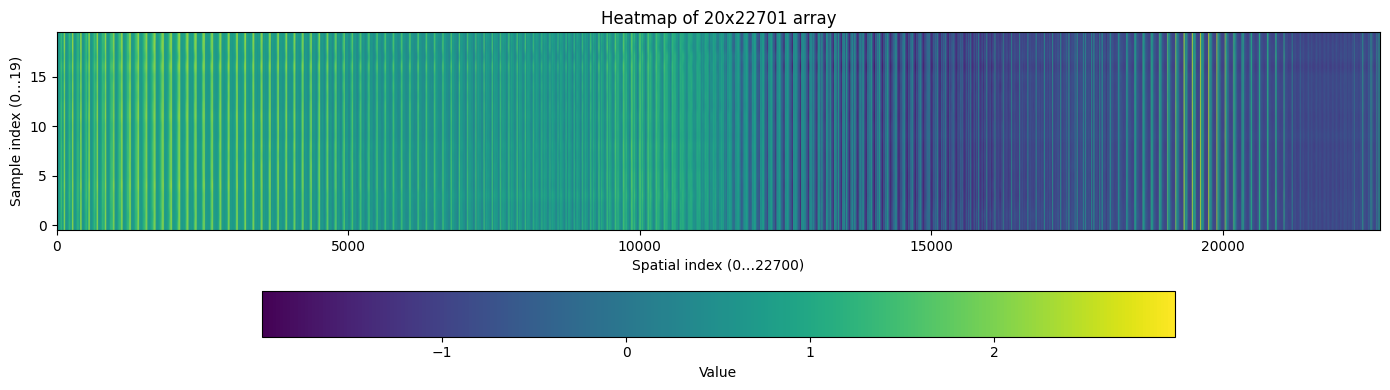

In [ ]:
# print(len(logit_vals_hist)) # 215
print(logit_vals_hist[0].shape)

arr = logit_vals_hist[0]

ig, ax = plt.subplots(figsize=(14, 4))  # wide figure for many columns

# Plot the heatmap
im = ax.imshow(
    arr,
    aspect='auto',        # lets the x‑axis span all 22701 cols
    cmap='viridis',       # or 'plasma', 'inferno', etc.
    origin='lower'        # row 0 at bottom; use 'upper' if you prefer
)

# Labels
ax.set_xlabel('Spatial index (0…22700)')
ax.set_ylabel('Sample index (0…19)')
ax.set_title('Heatmap of 20x22701 array')

# Colorbar
cbar = fig.colorbar(im, ax=ax, orientation='horizontal', pad=0.2)
cbar.set_label('Value')

plt.tight_layout()
plt.show()

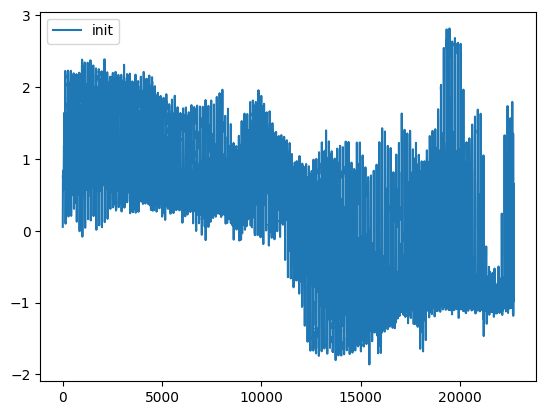

In [53]:
arr = logit_vals_hist[-1]
# arr_softmaxed = jax.nn.softmax(arr, axis = 1)

# print(logit_vals_hist[0][0].min(), ":", arr[0].max())

plt.plot(logit_vals_hist[0][5], label = 'init')
# plt.plot(logit_vals_hist[-1][5], label = 'final')
plt.legend()

# print(arr.shape) # (20, 22701)

logit_vals_softmaxed = []
for i in range(len(logit_vals_hist)):
    logit_vals_softmaxed.append(  jax.nn.softmax(logit_vals_hist[i], axis = -1)  )



In [52]:
# plt.plot(logit_vals_softmaxed[0][5], label = 'init')
# plt.plot(logit_vals_softmaxed[-1][5], label = 'final')
# plt.legend()
# print(arr.shape) # (20, 22701)


print(np.argmax(logit_vals_hist[0][5]), ":", logit_vals_hist[0][5][ np.argmax(logit_vals_hist[0][5]) ])
min_val, max_val = logit_vals_hist[0][5].min(), logit_vals_hist[0][5].max()
print(min_val, max_val)


print(np.argmax(logit_vals_softmaxed[0][5]), ":", logit_vals_softmaxed[0][5][ np.argmax(logit_vals_softmaxed[0][5]) ])
min_val, max_val = logit_vals_softmaxed[0][5].min(), logit_vals_softmaxed[0][5].max()
print(min_val, max_val)

# print(np.sum(logit_vals_softmaxed[0][5]))

print("___________________________")

print(np.argmax(logit_vals_hist[-1][5]), ":", logit_vals_hist[-1][5][ np.argmax(logit_vals_hist[-1][5]) ])
min_val, max_val = logit_vals_hist[-1][5].min(), logit_vals_hist[-1][5].max()
print(min_val, max_val)


print(np.argmax(logit_vals_softmaxed[-1][5]), ":", logit_vals_softmaxed[-1][5][ np.argmax(logit_vals_softmaxed[-1][5]) ])
min_val, max_val = logit_vals_softmaxed[-1][5].min(), logit_vals_softmaxed[-1][5].max()
print(min_val, max_val)





19468 : 2.8157275
-1.8609895 2.8157275
19468 : 0.0004001941
3.7256189e-06 0.0004001941
___________________________
18637 : 83.69263
-9.460548 83.69263
18637 : 0.9931385
3.4762e-41 0.9931385


/tmp/ipykernel_2219354/1902618802.py:19: UserWarning: Adding colorbar to a different Figure <Figure size 1400x400 with 2 Axes> than <Figure size 800x600 with 1 Axes> which fig.colorbar is called on.
  cbar = fig.colorbar(im, ax=ax, orientation='horizontal', pad=0.2)


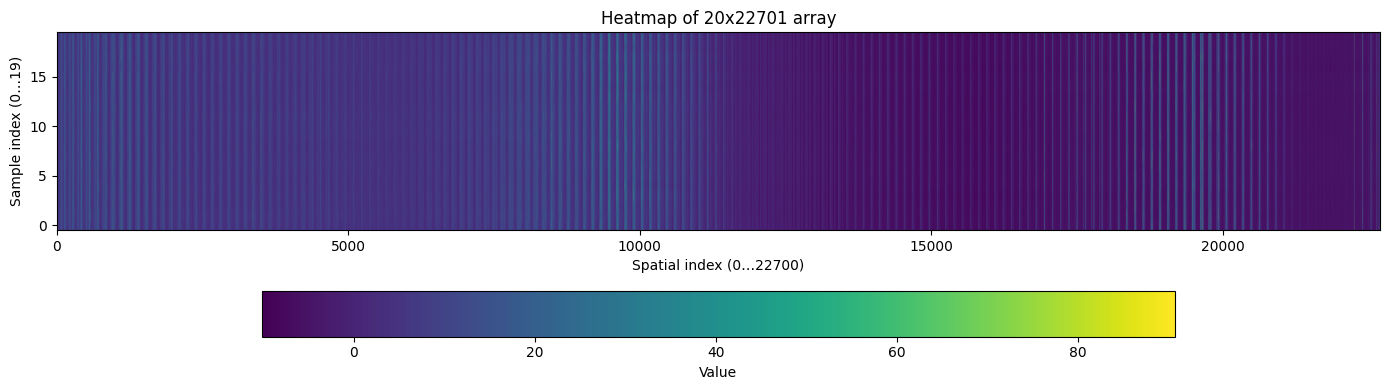

In [ ]:
# arr = logit_vals_hist[-1]

# ig, ax = plt.subplots(figsize=(14, 4))  # wide figure for many columns

# # Plot the heatmap
# im = ax.imshow(
#     arr,
#     aspect='auto',        # lets the x‑axis span all 22701 cols
#     cmap='viridis',       # or 'plasma', 'inferno', etc.
#     origin='lower'        # row 0 at bottom; use 'upper' if you prefer
# )

# # Labels
# ax.set_xlabel('Spatial index (0…22700)')
# ax.set_ylabel('Sample index (0…19)')
# ax.set_title('Heatmap of 20x22701 array')

# # Colorbar
# cbar = fig.colorbar(im, ax=ax, orientation='horizontal', pad=0.2)
# cbar.set_label('Value')

# plt.tight_layout()
# plt.show()